In [2]:
%pylab inline
import os
import time
import glob
import operator
import xarray as xr
import summa_plot as sp
import pysumma.Simulation
import scipy.stats
import matplotlib as mpl
from pprint import pprint
from functools import reduce
from scipy.special import psi, inv_boxcox
from jupyterthemes import jtplot
from sklearn.neighbors import NearestNeighbors
import pandas as pd
import importlib
from jupyterthemes import jtplot
importlib.reload(pysumma.Simulation)

jtplot.style('grade3', fscale=1.3)
jtplot.figsize(x=18, y=10)
mpl.rcParams['figure.figsize'] = (18, 10)

MM_PER_M = 1000
SEC_PER_MIN = 60
MIN_PER_HOUR = 60
HOUR_PER_DAY = 24
DAY_PER_YEAR = 365
# Timestep is 1 hour in our case
SEC_PER_TIMESTEP = SEC_PER_MIN * MIN_PER_HOUR

user = os.environ['USER']
sites = ['Amplero', 'Blodgett', 'Bugac', 'ElSaler', 'ElSaler2', 'Espirra', 'FortPeck', 
         'Harvard', 'Hesse', 'Howard', 'Howlandm', 'Hyytiala', 'Kruger', 'Loobos', 'Merbleue',
         'Mopane', 'Palang', 'Sylvania', 'Tumba', 'UniMich']
soil_moisture_sites = ['Amplero', 'Blodgett', 'ElSaler', 'ElSaler2', 'FortPeck', 'Hesse', 
                       'Hyytiala', 'Kruger', 'Loobos', 'Mopane', 'Sylvania']
fman_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/summa_zFileManager_{}.txt"
oc_template = "/pool0/data/"+user+"/PLUMBER_data/sites/{}/settings/meta/summa_zModelOutput.txt"
fman_dict = {s: fman_template.format(s, s) for s in sites}

#fman_template = "/pool0/data/tushark/PLUMBER_data/sites/{}/settings/summa_zFileManager_{}.txt"
#fman_dict = {s: fman_template.format(s, s) for s in sites}

Populating the interactive namespace from numpy and matplotlib


In [3]:
def raw_data(data_array):
    """Unpacks data into a flat array"""
    eps = 1e-12
    return data_array.values.flatten() + eps * np.random.random(data_array.shape)


def good_inds(x, strict=False):
    """Remove invalid data"""
    if strict:
        return np.where(np.logical_and(x > 1e-10, x < 3000))[0]
    return np.where(np.logical_and(x > -3000, x < 3000))[0]


def nearest_distances(X, k=1):
    """Compute distances to kth nearest neighbors"""
    knn = NearestNeighbors(n_neighbors=k, metric='chebyshev')
    knn.fit(X)
    d, _ = knn.kneighbors(X)
    return d[:, -1]


def marginal_neighbors(X, R):
    """Compute number of neighbors in R-radius ball"""
    knn = NearestNeighbors(metric='chebyshev')
    knn.fit(X)
    return [len(knn.radius_neighbors(p.reshape(1, -1), r)[0][0])
            for p, r in zip(X, R)]


def entropy_sk(X, k=False):
    """Compute entropy H(X1, X2,..., Xn)"""
    try:
        n, d = X.shape
    except Exception as e:
        X = X.reshape(-1, 1)
        n, d = X.shape
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(X, k) + eps * np.random.random(n)
    n, d = X.shape
    ent = d * np.log(np.mean(r)) + psi(n) - psi(k) + d * np.log(2)
    return ent


def mutual_info(x, y, k=False):
    """Compute I(X; Y)"""
    n = len(x)
    if not k:
        k = 10#int(np.sqrt(n))
    eps = 1e-12
    r = nearest_distances(np.array([x, y]).T, k) + eps * np.random.random(n)
    n_x = marginal_neighbors(x.reshape(-1,1), r)
    n_y = marginal_neighbors(y.reshape(-1,1), r)
    psi_x = psi(n_x)
    psi_y = psi(n_y)
    return (psi(n) + psi(k) - (1./k) - np.mean(psi_x + psi_y))


def conditional_mutual_info(X, k=False):
    """Compute I(X1; X2 | X3:n)"""
    xz = np.array([X[0], *X[2:]]).T
    yz = np.array([X[1], *X[2:]]).T
    z = np.array(X[2:]).T
    d, n = X.shape
    if not k:
        k = 10
    eps = 1e-12
    r = nearest_distances(X.T, k) + eps * np.random.random(n)
    psi_xz = psi(marginal_neighbors(xz, r))
    psi_yz = psi(marginal_neighbors(yz, r))
    psi_z = psi(marginal_neighbors(z, r))
    return (psi(k) - np.mean(psi_xz + psi_yz - psi_z))

def transfer_entropy(X: np.array, lag: int) -> float:
    """
    Computes TE(X2_t; X1_{t-lag} | X2_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip] will compute
           the information transferred from precip to evap,
        lag: The time-offset to consider (in timesteps).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    assert len(X) == 2
    # Subsample data and put it together with combination list
    sample_size = np.min([5000, len(X[0])-lag])
    max_start = len(X[0]) - sample_size - lag
    idx = np.random.choice(np.arange(len(X[0])) - lag, sample_size)
    ans = [X[1][idx]]
    ans.append(X[0][idx-lag])
    ans.append(X[1][idx-lag])
    return conditional_mutual_info(np.array(ans))
   

def conditional_transfer_entropy(X: np.array, lag: int) -> float:
    """
    Computes TE(X1_t; X2_{t-lag} | X3:n_{t-lag}, X1_{t-lag})

    Args:
        X: A list containing multiple timeseries.
           Example: [evap, precip, runoff] will compute
           the information transferred from precip to evap,
           eliminating any effects from runoff.
        lag: The time-offset to consider (in days).

    Returns:
        The value of the equation given above.  Small values
        denote less of a connection.  Negative values are
        possible, but should be thrown out - as they are
        numerical artifacts.
    """
    # Need at least 3 variables to compute the TE
    assert len(X) > 2
    # Subsample data and put it together with combination list
    sample_size = np.min([5000, len(X[0])-lag])
    max_start = len(X[0]) - sample_size - lag
    idx = np.random.choice(np.arange(len(X[0])) - lag, sample_size)
    ans = [X[0][idx]]
    ans.append(X[1][idx-lag])
    for v in X[2:]:
        ans.append(v[idx])
    ans.append(X[0][idx-lag])
    return conditional_mutual_info(np.array(ans))


In [4]:
wb_vars = ['pptrate', 'scalarGroundEvaporation', 'scalarCanopyEvaporation',
           'scalarSnowSublimation', 'scalarCanopySublimation', 'scalarTotalRunoff', 
           'scalarSWE', 'scalarTotalSoilLiq',  'scalarTotalSoilIce', 
           'scalarCanopyIce', 'scalarCanopyLiq', 'scalarCanopyTranspiration', 
           'scalarLatHeatTotal', 'scalarSenHeatTotal', 'airtemp', 'SWRadAtm']

wb_dict = {
    'precip': ['pptrate'],
    'evap': ['scalarGroundEvaporation', 'scalarCanopyEvaporation', 'scalarCanopyTranspiration', 
             'scalarSnowSublimation', 'scalarCanopySublimation'],
    'runoff': ['scalarTotalRunoff'],
    'swe': ['scalarSWE'],
    'soil_moisture': ['scalarTotalSoilLiq', 'scalarTotalSoilIce'],
    'canopy_moisture': ['scalarCanopyIce', 'scalarCanopyLiq'],
    'latent_heat': ['scalarLatHeatTotal'],
    'sensible_heat': ['scalarSenHeatTotal'],
    'temperature': ['airtemp'],
    'shortwave': ['SWRadAtm']
}

wb_multiplier = {
    'precip': SEC_PER_TIMESTEP,
    'evap': SEC_PER_TIMESTEP,
    'runoff': SEC_PER_TIMESTEP * MM_PER_M,
    'swe': 1,
    'soil_moisture': 1,
    'canopy_moisture': 1,
    'latent_heat': -1,
    'sensible_heat': -1,
    'temperature': 1,
    'shortwave': 1
}

In [5]:
def postprocess(ds):
    """
    Aggregate subcomponents and convert units for the
    output variables of interest. This also removes
    the unnecessary hru dimension
    """
    for k, v in wb_dict.items():
        ds[k] = reduce(operator.add, [ds[vv] for vv in v]) * wb_multiplier[k]
    ds = ds[list(wb_dict.keys())].isel(hru=0, drop=True)
    ds['dswe'] = ds['swe'].diff(dim='time')
    ds['dsoil_moisture'] = ds['soil_moisture'].diff(dim='time')
    return ds

def create_sim_obj(site):
    """
    Create the simulation object for a particular
    location and set the necessary output variables
    """
    s = pysumma.Simulation.Simulation(fman_dict[site])
    s.executable = '/opt/local/bin/summa.exe'
    s.library_path = '$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH'
    o = s.output_control
    for v in wb_vars:
        o.set_option(v, 1)
    o.write()
    return s

def run_summa(site):
    """Kick off a SUMMA simulation for a given location"""
    s = create_sim_obj(site)
    additional_args = ['export OMP_NUM_THREADS=8']
    return s.execute('test', 'local', additional_args)

def monitor(proc):
    """Watch the SUMMA simulation until it has completed"""
    res = proc.wait()
    return res, proc.stdout.read(), proc.stderr.read()

def set_decision(simulation, decision_key, decision_value):
    """Change a decision"""
    simulation.decision_obj.__dict__[decision_key].value = decision_value

In [5]:
def run_summa(site):
    s = create_sim_obj(site)
    #s.decision_obj.stomResist.value = 'simpleResistance'
    # s.decision_obj.groundwatr = 'noXplict'
    #s.decision_obj.bcLowrSoiH.value = 'zeroFlux'
    #s.decision_obj.__dict__['rootProfil'].value = 'powerLaw'
    #s.decision_obj.__dict__['hc_profile'].value = 'pow_prof'
    set_decision(s, 'groundwatr', 'qTopmodl')
    set_decision(s, 'bcLowrSoiH', 'zeroFlux')
    set_decision(s, 'f_Richards', 'mixdform')
    set_decision(s, 'rootProfil', 'powerLaw')
    set_decision(s, 'hc_profile', 'pow_prof')
    additional_args = ['export OMP_NUM_THREADS=8']
    return s.execute('test_simpleResistance_2', 'local', additional_args)

In [6]:
def run_combinations2(dataframe, sites):
    '''
    This function takes a dataframe with summa
    decision points as column names, and with each
    row representing a summa run with the appropriate
    decision options
    It also takes an array_like object sites which just
    lists the names of the sites for which each summa
    combination should be run at.
    '''
    out_result = []
    err_result = []
    stdout_result = []
    results = []
    #name_template = ''
    
    # assuming we want to run all sites
    # another option would be to have a column in the 
    # dataframe representing the site for each run
    for site in sites:
        
        # for each option combination, set the appropriate
        # values in the decision object, then run
        for index in dataframe.index.values:
            
            # set up a simulation object for the site
            s = create_sim_obj(site)
            additional_args = ['export OMP_NUM_THREADS=8']
            set_decision(s, 'groundwatr', 'qTopmodl')
            set_decision(s, 'bcLowrSoiH', 'zeroFlux')
            set_decision(s, 'f_Richards', 'mixdform')
            set_decision(s, 'rootProfil', 'powerLaw')
            set_decision(s, 'hc_profile', 'pow_prof')
            name = ''
            
            for decision in dataframe.columns.values:
                
                print(index, decision, dataframe[decision][index])
                set_decision(s, decision, dataframe[decision][index])
                name += dataframe[decision][index] + '_'
                
            # need naming convention for output files
            #name +=  name_template.format()
            proc, out_file = s.execute(name, 'local', additional_args)
            res, out, err = monitor(proc)
            results.append(res)
            out_result.append(out_file)
            stdout_result.append(out)
            err_result.append(err)
    
    return results, out_result, err_result, stdout_result         

In [7]:
df1 = pd.DataFrame(columns=['canopyEmis', 'windPrfile', 'stomResist'])

In [8]:
dict1 = {'canopyEmis':'simplExp', 'windPrfile':'exponential', 'stomResist':'BallBerry'}

In [9]:
dicts = [{'canopyEmis':'simplExp', 'windPrfile':'exponential', 'stomResist':'BallBerry'},
         {'canopyEmis':'simplExp', 'windPrfile':'logBelowCanopy', 'stomResist':'BallBerry'},
         {'canopyEmis':'difTrans', 'windPrfile':'exponential', 'stomResist':'BallBerry'},
         {'canopyEmis':'difTrans', 'windPrfile':'logBelowCanopy', 'stomResist':'BallBerry'}, 
         {'canopyEmis':'simplExp', 'windPrfile':'exponential', 'stomResist':'Jarvis'},
         {'canopyEmis':'simplExp', 'windPrfile':'logBelowCanopy', 'stomResist':'Jarvis'},
         {'canopyEmis':'difTrans', 'windPrfile':'exponential', 'stomResist':'Jarvis'},
         {'canopyEmis':'difTrans', 'windPrfile':'logBelowCanopy', 'stomResist':'Jarvis'}]

In [10]:
df3 = df1.append(dict1, ignore_index=True)

In [11]:
df3

,canopyEmis,windPrfile,stomResist
0,simplExp,exponential,BallBerry


In [12]:
df2 = df1.append(dicts)

In [13]:
df2

,canopyEmis,windPrfile,stomResist
0,simplExp,exponential,BallBerry
1,simplExp,logBelowCanopy,BallBerry
2,difTrans,exponential,BallBerry
3,difTrans,logBelowCanopy,BallBerry
4,simplExp,exponential,Jarvis
5,simplExp,logBelowCanopy,Jarvis
6,difTrans,exponential,Jarvis
7,difTrans,logBelowCanopy,Jarvis


In [14]:
sites_short = ['Sylvania']

In [15]:
res, file, err, out = run_combinations2(df3, sites_short)
for number in res:
    if number > 0:
        print(out)
        print(err)

0 canopyEmis simplExp
0 windPrfile exponential
0 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_exponential_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/Sylvania/settings/summa_zFileManager_Sylvania.txt


In [16]:
file

['/data/tushark/PLUMBER_data/sites/Sylvania/summa_output/Sylvania_output_simplExp_exponential_BallBerry__timestep.nc']

In [17]:
file[0]

'/data/tushark/PLUMBER_data/sites/Sylvania/summa_output/Sylvania_output_simplExp_exponential_BallBerry__timestep.nc'

In [19]:
bench_files

['/pool0/data/tushark/PLUMBER_data/sites/ElSaler2/benchmark/ElSaler2Fluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/Howlandm/benchmark/HowlandmFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/Merbleue/benchmark/MerbleueFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/Sylvania/benchmark/SylvaniaFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/Amplero/benchmark/AmpleroFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/Kruger/benchmark/KrugerFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/FortPeck/benchmark/FortPeckFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/Bugac/benchmark/BugacFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/UniMich/benchmark/UniMichFluxnet_1.4_PLUMBER_benchmarks.nc',
 '/pool0/data/tushark/PLUMBER_data/sites/ElSaler/benchmark/ElSalerFluxnet_1.4_

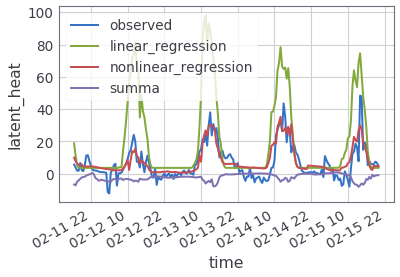

In [20]:
out_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/summa_output/*output*.nc', recursive=True)
bench_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/benchmark/*.nc', recursive=True)
obs_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/observations/fluxes/*.nc', recursive=True)
met_files = glob.glob('/pool0/data/tushark/PLUMBER_data/sites/**/observations/met/*.nc', recursive=True)



output =  postprocess(xr.open_dataset('/pool0/data/tushark/PLUMBER_data/sites/Sylvania/summa_output/Sylvania_output_simplExp_exponential_BallBerry_timestep.nc'))

obs = xr.open_dataset(obs_files[3])
bench = xr.open_dataset(bench_files[3])
met = xr.open_dataset(met_files[3])

ts = slice(2000, 2200)
obs['Qle'].isel(time=ts).plot(label='observed', linewidth=2)
bench['Qle_1lin'].isel(time=ts).plot(label='linear_regression', linewidth=2)
bench['Qle_3km27'].isel(time=ts).plot(label='nonlinear_regression', linewidth=2)
(-output['latent_heat']).isel(time=ts).plot(label='summa', linewidth=2)
plt.legend()

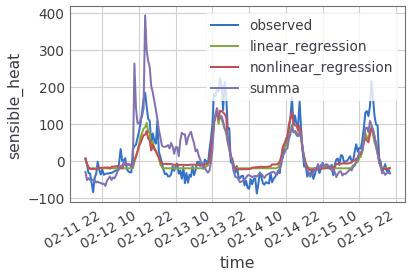

In [23]:
obs['Qh'].isel(time=ts).plot(label='observed', linewidth=2)
bench['Qh_1lin'].isel(time=ts).plot(label='linear_regression', linewidth=2)
bench['Qh_3km27'].isel(time=ts).plot(label='nonlinear_regression', linewidth=2)
(output['sensible_heat']).isel(time=ts).plot(label='summa', linewidth=2)
plt.legend()

In [25]:
soil_moisture_sites[:3]

['Amplero', 'Blodgett', 'ElSaler']

In [26]:
res1 = res
file1 = file
err1 = err
out1 = out

In [27]:
out1

[b"file_suffix is 'simplExp_exponential_BallBerry_'.\nfile_master is '/pool0/data/tushark/PLUMBER_data/sites/Sylvania/settings/summa_zFileManager_Sylvania.txt'.\nstart at 13:17:50\nName of Model Output control file: /data/tushark/PLUMBER_data/sites/Sylvania/settings/meta/summa_zModelOutput.txt\ndecisions file =  /data/tushark/PLUMBER_data/sites/Sylvania/settings/summa_zDecisions_Sylvania.txt\n   1 simulStart: 2002-01-01 00:30\n   2 simulFinsh: 2006-01-01 00:00\n   3 soilCatTbl: ROSETTA\n   4 vegeParTbl: USGS\n   5 soilStress: NoahType\n   6 stomResist: BallBerry\n   7 bbTempFunc: q10Func\n   8 bbHumdFunc: humidLeafSurface\n   9 bbElecFunc: linear\n  10 bbCO2point: origBWB\n  11 bbNumerics: NoahMPsolution\n  12 bbAssimFnc: minFunc\n  13 bbCanIntg8: constantScaling\n  14 num_method: itertive\n  15 fDerivMeth: analytic\n  16 LAI_method: monTable\n  17 cIntercept: storageFunc\n  18 f_Richards: mixdform\n  19 groundwatr: qTopmodl\n  20 hc_profile: pow_prof\n  21 bcUpprTdyn: nrg_flux\n  22 b

In [28]:
res2, file2, err2, out2 = run_combinations2(df2, soil_moisture_sites[:3])
for number in res:
    if number > 0:
        print(out)
        print(err)

0 canopyEmis simplExp
0 windPrfile exponential
0 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_exponential_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/Amplero/settings/summa_zFileManager_Amplero.txt
1 canopyEmis simplExp
1 windPrfile logBelowCanopy
1 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_logBelowCanopy_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/Amplero/settings/summa_zFileManager_Amplero.txt
2 canopyEmis difTrans
2 windPrfile exponential

In [29]:
res2

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

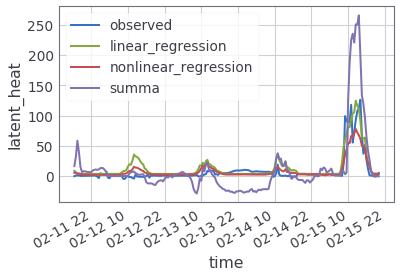

In [50]:
output =  postprocess(xr.open_dataset('/pool0//data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_simplExp_logBelowCanopy_BallBerry_timestep.nc'))

obs = xr.open_dataset(obs_files[12])
bench = xr.open_dataset(bench_files[12])
met = xr.open_dataset(met_files[12])

ts = slice(2000, 2200)
obs['Qle'].isel(time=ts).plot(label='observed', linewidth=2)
bench['Qle_1lin'].isel(time=ts).plot(label='linear_regression', linewidth=2)
bench['Qle_3km27'].isel(time=ts).plot(label='nonlinear_regression', linewidth=2)
(-output['latent_heat']).isel(time=ts).plot(label='summa', linewidth=2)
plt.legend()

In [38]:
out2[0]

b"file_suffix is 'simplExp_exponential_BallBerry_'.\nfile_master is '/pool0/data/tushark/PLUMBER_data/sites/Blodgett/settings/summa_zFileManager_Blodgett.txt'.\nstart at 16:40:00\nName of Model Output control file: /data/tushark/PLUMBER_data/sites/Blodgett/settings/meta/summa_zModelOutput.txt\ndecisions file =  /data/tushark/PLUMBER_data/sites/Blodgett/settings/summa_zDecisions_Blodgett.txt\n   1 simulStart: 2002-01-01 00:30\n   2 simulFinsh: 2007-01-01 00:00\n   3 soilCatTbl: ROSETTA\n   4 vegeParTbl: USGS\n   5 soilStress: NoahType\n   6 stomResist: BallBerry\n   7 bbTempFunc: q10Func\n   8 bbHumdFunc: humidLeafSurface\n   9 bbElecFunc: linear\n  10 bbCO2point: origBWB\n  11 bbNumerics: NoahMPsolution\n  12 bbAssimFnc: minFunc\n  13 bbCanIntg8: constantScaling\n  14 num_method: itertive\n  15 fDerivMeth: analytic\n  16 LAI_method: monTable\n  17 cIntercept: storageFunc\n  18 f_Richards: mixdform\n  19 groundwatr: qTopmodl\n  20 hc_profile: pow_prof\n  21 bcUpprTdyn: nrg_flux\n  22 bc

In [30]:
res3, file3, err3, out3 = run_combinations2(df2, soil_moisture_sites[3:6])
for number in res:
    if number > 0:
        print(out)
        print(err)

0 canopyEmis simplExp
0 windPrfile exponential
0 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_exponential_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/ElSaler2/settings/summa_zFileManager_ElSaler2.txt
1 canopyEmis simplExp
1 windPrfile logBelowCanopy
1 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_logBelowCanopy_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/ElSaler2/settings/summa_zFileManager_ElSaler2.txt
2 canopyEmis difTrans
2 windPrfile exponen

In [31]:
res3

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [33]:
res4, file4, err4, out4 = run_combinations2(df2, soil_moisture_sites[6:])
for number in res:
    if number > 0:
        print(out)
        print(err)

0 canopyEmis simplExp
0 windPrfile exponential
0 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_exponential_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/Hyytiala/settings/summa_zFileManager_Hyytiala.txt
1 canopyEmis simplExp
1 windPrfile logBelowCanopy
1 stomResist BallBerry
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8
export LD_LIBRARY_PATH="$HOME/software/lib:/opt/local/lib:/opt/local/lib64:$LD_LIBRARY_PATH" && export OMP_NUM_THREADS=8 && /opt/local/bin/summa.exe -p never -s simplExp_logBelowCanopy_BallBerry_ -m /pool0/data/tushark/PLUMBER_data/sites/Hyytiala/settings/summa_zFileManager_Hyytiala.txt
2 canopyEmis difTrans
2 windPrfile exponen

In [34]:
res4

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0]

In [58]:
res2

[0, 0, 0, 0, 0, 0, 0, 0]

In [59]:
res3

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [63]:
err4[15]

b'Note: The following floating-point exceptions are signalling: IEEE_INVALID_FLAG IEEE_UNDERFLOW_FLAG IEEE_DENORMAL\n'

In [64]:
soil_moisture_sites[6]

'Hyytiala'

In [68]:
out4[16]

b"file_suffix is 'simplExp_exponential_BallBerry_'.\nfile_master is '/pool0/data/tushark/PLUMBER_data/sites/Kruger/settings/summa_zFileManager_Kruger.txt'.\nstart at 21:31:43\nName of Model Output control file: /data/tushark/PLUMBER_data/sites/Kruger/settings/meta/summa_zModelOutput.txt\ndecisions file =  /data/tushark/PLUMBER_data/sites/Kruger/settings/summa_zDecisions_Kruger.txt\n   1 simulStart: 2002-01-01 00:30\n   2 simulFinsh: 2004-01-01 00:00\n   3 soilCatTbl: ROSETTA\n   4 vegeParTbl: USGS\n   5 soilStress: NoahType\n   6 stomResist: BallBerry\n   7 bbTempFunc: q10Func\n   8 bbHumdFunc: humidLeafSurface\n   9 bbElecFunc: linear\n  10 bbCO2point: origBWB\n  11 bbNumerics: NoahMPsolution\n  12 bbAssimFnc: minFunc\n  13 bbCanIntg8: constantScaling\n  14 num_method: itertive\n  15 fDerivMeth: analytic\n  16 LAI_method: monTable\n  17 cIntercept: storageFunc\n  18 f_Richards: mixdform\n  19 groundwatr: qTopmodl\n  20 hc_profile: pow_prof\n  21 bcUpprTdyn: nrg_flux\n  22 bcLowrTdyn: 

In [73]:
res = res1 + res2 + res3 + res4
err = err1 + err2 + err3 + err4
file = file1 + file2 + file3 + file4
#out = out1 + out2 + out3 + out4

In [75]:
file2

['/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_simplExp_exponential_BallBerry__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_simplExp_logBelowCanopy_BallBerry__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_difTrans_exponential_BallBerry__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_difTrans_logBelowCanopy_BallBerry__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_simplExp_exponential_Jarvis__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_simplExp_logBelowCanopy_Jarvis__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_difTrans_exponential_Jarvis__timestep.nc',
 '/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_difTrans_logBelowCanopy_Jarvis__timestep.nc']

In [7]:
test = xr.open_dataset('/pool0/data/tushark/PLUMBER_data/sites/Blodgett/summa_output/Blodgett_output_difTrans_logBelowCanopy_Jarvis_timestep.nc')

In [16]:
test['pptrate'][4]

<xarray.DataArray 'pptrate' (hru: 1)>
array([ 0.])
Coordinates:
    time     datetime64[ns] 2000-01-01T02:29:59.999986
  * hru      (hru) int32 1
Attributes:
    long_name:  precipitation rate (instant)
    units:      kg m-2 s-1